In [5]:
from subsite_gen import generate_subslice
from fabrictestbed_extensions.fablib.fablib import FablibManager as fablib_manager

fablib = fablib_manager()

slice_name = "lab1"
switch_site = 'NEWY'
server_sites = ['RUTG', 'MASS']

slice = fablib.new_slice(name=slice_name)

slice = generate_subslice(1, slice, switch_site, server_sites)
slice.submit()


Retry: 9, Time: 272 sec


ID,698e41a2-5aea-4ceb-9f51-2d185d2092c1
Name,lab1
Lease Expiration (UTC),2024-07-10 13:43:40 +0000
Lease Start (UTC),2024-07-09 13:43:42 +0000
Project ID,16eafd43-3e6c-4546-854c-935eea16552a
State,StableOK


ID,Name,Cores,RAM,Disk,Image,Image Type,Host,Site,Username,Management IP,State,Error,SSH Command,Public SSH Key File,Private SSH Key File
9c23390e-de2c-41ce-9f0f-aa34c27127ff,server1,4,8,100,default_ubuntu_20,qcow2,rutg-w3.fabric-testbed.net,RUTG,ubuntu,2620:0:d61:4101:f816:3eff:fe6e:87cb,Active,,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2620:0:d61:4101:f816:3eff:fe6e:87cb,/home/fabric/work/fabric_config/slice_key.pub,/home/fabric/work/fabric_config/slice_key
15dc7b56-4f85-49cc-b186-0a544c31429f,server2,4,8,100,default_ubuntu_20,qcow2,mass-w3.fabric-testbed.net,MASS,ubuntu,2001:48e8:6401:3:f816:3eff:fe95:24ab,Active,,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2001:48e8:6401:3:f816:3eff:fe95:24ab,/home/fabric/work/fabric_config/slice_key.pub,/home/fabric/work/fabric_config/slice_key
ec2fd035-cfd8-4b09-ba1b-b5eddbea6ab1,sub_switch1,32,16,100,default_ubuntu_20,qcow2,newy-w2.fabric-testbed.net,NEWY,ubuntu,2001:400:a100:3040:f816:3eff:fefe:9583,Active,,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2001:400:a100:3040:f816:3eff:fefe:9583,/home/fabric/work/fabric_config/slice_key.pub,/home/fabric/work/fabric_config/slice_key


ID,Name,Layer,Type,Site,Subnet,Gateway,State,Error
ca5d3125-88e7-42b9-99f7-ffae0010e959,net1,L2,L2STS,None,None,None,Active,
00a7c2b3-c630-4240-bf48-c10a7cc404b2,net2,L2,L2STS,None,None,None,Active,


Name,Short Name,Node,Network,Bandwidth,Mode,VLAN,MAC,Physical Device,Device,IP Address,Numa Node
server1-None-p1,p1,server1,net1,100,config,,06:23:26:0D:F8:9D,enp7s0,enp7s0,None,4
server2-None-p1,p1,server2,net2,100,config,,02:97:B3:00:67:D3,enp7s0,enp7s0,None,4
sub_switch1-net1_nic-p1,p1,sub_switch1,net1,100,config,,1A:6B:AC:C9:57:69,enp8s0,enp8s0,None,4
sub_switch1-net2_nic-p1,p1,sub_switch1,net2,100,config,,1A:45:06:22:24:7A,enp7s0,enp7s0,None,4



Time to print interfaces 278 seconds


'698e41a2-5aea-4ceb-9f51-2d185d2092c1'

In [6]:
switch = slice.get_node(name="sub_switch1")
switch.upload_file('../scripts/install_bmv2.sh', 'install_bmv2.sh')
stdout, stderr = switch.execute(f'chmod +x install_bmv2.sh && ./install_bmv2.sh', quiet=True)


server1 = slice.get_node(name="server1")
server2 = slice.get_node(name="server2")
stdout, stderr = server1.execute(f'sudo apt-get install -y net-tools', quiet=True)
stdout, stderr = server2.execute(f'sudo apt-get install -y net-tools', quiet=True)
stdout, stderr = switch.execute(f'sudo apt-get install -y net-tools', quiet=True)


node1_iface = server1.get_interface(network_name='net1') 
server1_iface_name = node1_iface.get_device_name()
print(f'server1_iface: {server1_iface_name}')

node2_iface = server2.get_interface(network_name='net2') 
server2_iface_name = node2_iface.get_device_name()
print(f'server2_iface: {server2_iface_name}')

switch_iface1 = switch.get_interface(network_name='net1') 
switch_iface1_name = switch_iface1.get_device_name()
print(f'switch_iface1: {switch_iface1_name}')

switch_iface2 = switch.get_interface(network_name='net2') 
switch_iface2_name = switch_iface2.get_device_name()
print(f'switch_iface2: {switch_iface2_name}')


stdout, stderr = server1.execute(f'sudo ip link set dev {server1_iface_name} up', quiet=True)
stdout, stderr = server2.execute(f'sudo ip link set dev {server2_iface_name} up', quiet=True)
stdout, stderr = switch.execute(f'sudo ip link set dev {switch_iface1_name} up', quiet=True)
stdout, stderr = switch.execute(f'sudo ip link set dev {switch_iface2_name} up', quiet=True)


server1_iface_MAC = '00:00:00:00:00:01'
switch_iface1_MAC = '00:00:00:00:00:02'
switch_iface2_MAC = '00:00:00:00:00:03'
server2_iface_MAC = '00:00:00:00:00:04'


server1_switch_subnet = "192.168.1.0/24"
server1_ip = '192.168.1.10/24'
switch_ip1 = '192.168.1.1/24'

stdout, stderr = server1.execute(f'sudo ifconfig {server1_iface_name} {server1_ip}')
stdout, stderr = switch.execute(f'sudo ifconfig {switch_iface1_name} {switch_ip1}')

stdout, stderr = server1.execute(f'sudo ifconfig {server1_iface_name} hw ether {server1_iface_MAC}')
stdout, stderr = switch.execute(f'sudo ifconfig {switch_iface1_name} hw ether {switch_iface1_MAC}')


server2_switch_subnet = "192.168.2.0/24"
server2_ip = '192.168.2.10/24'
switch_ip2 = '192.168.2.1/24'

stdout, stderr = server2.execute(f'sudo ifconfig {server2_iface_name} {server2_ip}')
stdout, stderr = switch.execute(f'sudo ifconfig {switch_iface2_name} {switch_ip2}')

stdout, stderr = server2.execute(f'sudo ifconfig {server2_iface_name} hw ether {server2_iface_MAC}')
stdout, stderr = switch.execute(f'sudo ifconfig {switch_iface2_name} hw ether {switch_iface2_MAC}')


stdout, stderr = switch.execute('sudo sysctl -w net.ipv4.ip_forward=1' , quiet=True)

stdout, stderr = switch.execute(f'sudo ip route del {server1_switch_subnet}', quiet=True)
stdout, stderr = switch.execute(f'sudo ip route del {server2_switch_subnet}', quiet=True)

gw1 = switch_ip1.split('/')[0] # gw1 -> 192.168.1.1 
gw2 = switch_ip2.split('/')[0] # gw2 -> 192.168.2.1
stdout, stderr = server1.execute(f'sudo ip route add {server2_switch_subnet} via {gw1}')
stdout, stderr = server2.execute(f'sudo ip route add {server1_switch_subnet} via {gw2}')

stdout, stderr = server1.execute(f'sudo arp -s {gw1} {switch_iface1_MAC}')
stdout, stderr = server2.execute(f'sudo arp -s {gw2} {switch_iface2_MAC}')

server1_iface: enp7s0
server2_iface: enp7s0
switch_iface1: enp8s0
switch_iface2: enp7s0


In [7]:
server1.execute(f'sudo apt-get update && sudo apt-get install -y python3-scapy', quiet=True)
server2.execute(f'sudo apt-get update && sudo apt-get install -y python3-scapy', quiet=True)

('Get:1 http://security.ubuntu.com/ubuntu focal-security InRelease [128 kB]\nHit:2 http://nova.clouds.archive.ubuntu.com/ubuntu focal InRelease\nGet:3 http://security.ubuntu.com/ubuntu focal-security/main amd64 Packages [3023 kB]\nGet:4 http://nova.clouds.archive.ubuntu.com/ubuntu focal-updates InRelease [128 kB]\nGet:5 http://security.ubuntu.com/ubuntu focal-security/main Translation-en [452 kB]\nGet:6 http://security.ubuntu.com/ubuntu focal-security/main amd64 c-n-f Metadata [14.0 kB]\nGet:7 http://security.ubuntu.com/ubuntu focal-security/restricted amd64 Packages [2927 kB]\nGet:8 http://security.ubuntu.com/ubuntu focal-security/restricted Translation-en [410 kB]\nGet:9 http://security.ubuntu.com/ubuntu focal-security/restricted amd64 c-n-f Metadata [544 B]\nGet:10 http://security.ubuntu.com/ubuntu focal-security/universe amd64 Packages [990 kB]\nGet:11 http://security.ubuntu.com/ubuntu focal-security/universe Translation-en [210 kB]\nGet:12 http://security.ubuntu.com/ubuntu focal-s

In [8]:
switch.execute(f'sudo pkill simple_switch')

('', '')

In [9]:
switch.upload_file('src/main.p4', 'main.p4')
stdout, stderr  = switch.execute(f'p4c main.p4')
stdout, stderr = switch.execute(f'sudo pkill simple_switch')
stdout, stderr = switch.execute(f'sudo simple_switch -i 0@{switch_iface1_name} -i 1@{switch_iface2_name} main.json &')

Calling target program-options parser
Adding interface enp8s0 as port 0
Adding interface enp7s0 as port 1


In [10]:
switch.upload_file('src/rules.sh', 'rules.sh')
stdout, stderr = switch.execute('chmod +x rules.sh && ./rules.sh')

Obtaining JSON from switch...
Done
Control utility for runtime P4 table manipulation
RuntimeCmd: Adding entry to lpm match table MyIngress.ipv4_lpm
match key:           LPM-c0:a8:01:00/24
action:              MyIngress.forward
runtime data:        00:00:00:00:00:01	00:00
Entry has been added with handle 0
RuntimeCmd: 
Obtaining JSON from switch...
Done
Control utility for runtime P4 table manipulation
RuntimeCmd: Adding entry to lpm match table MyIngress.ipv4_lpm
match key:           LPM-c0:a8:02:00/24
action:              MyIngress.forward
runtime data:        00:00:00:00:00:04	00:01
Entry has been added with handle 1
RuntimeCmd: 


In [11]:
server2_dest_ip = server2_ip.split('/')[0]
stdout, stderr = server1.execute(f'ping {server2_dest_ip} -c 3')

PING 192.168.2.10 (192.168.2.10) 56(84) bytes of data.
64 bytes from 192.168.2.10: icmp_seq=1 ttl=63 time=19.7 ms
64 bytes from 192.168.2.10: icmp_seq=2 ttl=63 time=19.1 ms
64 bytes from 192.168.2.10: icmp_seq=3 ttl=63 time=19.2 ms

--- 192.168.2.10 ping statistics ---
3 packets transmitted, 3 received, 0% packet loss, time 2003ms
rtt min/avg/max/mdev = 19.111/19.359/19.746/0.277 ms


In [28]:
switch.upload_file('../scripts/simple_switch_hp.gz', '/home/ubuntu/simple_switch_hp.gz')
switch.execute('gzip -d simple_switch_hp.gz')
switch.execute('chmod +x /home/ubuntu/simple_switch_hp')
stdout, stderr = switch.execute(f'sudo pkill switch')

 gzip: simple_switch_hp already exists;	not overwritten
 

In [12]:
switch.upload_file('../scripts/disable_offload.sh', 'disable_offload.sh')
stdout, stderr = switch.execute(f'sudo chmod +x ./disable_offload.sh && sudo ./disable_offload.sh {switch_iface1_name}', quiet=True)
stdout, stderr = switch.execute(f'sudo chmod +x ./disable_offload.sh && sudo ./disable_offload.sh {switch_iface2_name}', quiet=True)

In [32]:
#stdout, stderr = switch.execute(f'sudo /home/ubuntu/simple_switch_hp -i 0@{switch_iface1_name} -i 1@{switch_iface2_name} main.json &')
stdout, stderr = switch.execute('chmod +x rules.sh && ./rules.sh')

Obtaining JSON from switch...
Done
Control utility for runtime P4 table manipulation
RuntimeCmd: Adding entry to lpm match table MyIngress.ipv4_lpm
match key:           LPM-c0:a8:01:00/24
action:              MyIngress.forward
runtime data:        00:00:00:00:00:01	00:00
Entry has been added with handle 0
RuntimeCmd: 
Obtaining JSON from switch...
Done
Control utility for runtime P4 table manipulation
RuntimeCmd: Adding entry to lpm match table MyIngress.ipv4_lpm
match key:           LPM-c0:a8:02:00/24
action:              MyIngress.forward
runtime data:        00:00:00:00:00:04	00:01
Entry has been added with handle 1
RuntimeCmd: 


In [68]:
stdout, stderr = server1.execute(f'sudo apt-get update && sudo apt-get install -y iperf3', quiet=True)
stdout, stderr = server2.execute(f'sudo apt-get update && sudo apt-get install -y iperf3', quiet=True)

server2.execute_thread('iperf3 -s')
json_data, stderr = server1.execute('iperf3 -c 192.168.2.10 -J -t 100', quiet=True)
print("done")


done


In [72]:
import json
ans = json.loads(json_data)
y = []
x = []
for i in range(len(ans['intervals'])):
    x.append(i+1)
    y.append(ans['intervals'][i]['sum']['bits_per_second'] / (10**6))
    print(f"{ans['intervals'][i]['sum']['bits_per_second']:,}")

30,822,988.389852528
94,351,590.01931189
56,296,381.03871015
62,555,538.872350074
56,297,676.258696824
62,550,035.77133433
56,300,887.72179201
50,042,832.27543614
38,051,729.88287856
31,277,113.195885237
37,534,298.78092972
50,042,229.76064635
57,340,396.705030724
56,298,011.817636274
75,066,194.72913215
62,552,660.43586553
81,319,844.79937573
56,298,072.2186702
56,298,914.4910367
62,552,973.620774254
68,809,439.85937974
43,786,992.79855339
50,042,730.861040175
62,554,975.841265045
81,318,865.70700653
88,618,841.29222058
81,319,437.64919028
68,808,754.93393023
57,337,300.40891059
43,787,564.369017735
56,300,998.46843368
43,788,177.71465207
50,041,478.12887188
68,810,268.35030101
68,809,718.75508605
56,297,736.659010716
68,809,579.30695029
75,063,944.17058288
56,819,689.33586995
43,784,628.37791903
50,046,083.719491646
62,553,473.23176325
68,809,099.44562562
56,295,428.116981864
50,045,481.126405135
50,042,930.70744884
56,297,844.03766653
43,786,251.606109105
37,531,108.596653916
43,790

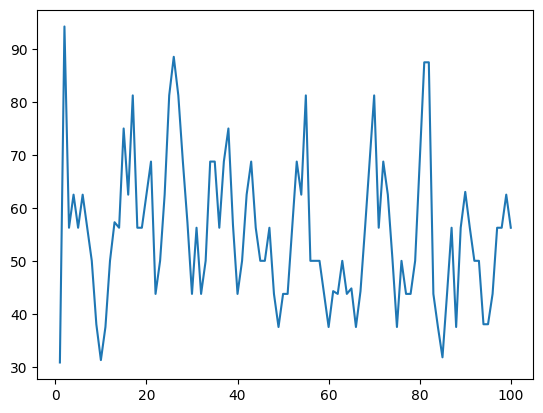

In [75]:
import matplotlib.pyplot as plt
plt.plot(x, y)

In [91]:
server2.execute_thread('iperf3 -s')
json_data, stderr = server1.execute('iperf3 -c 192.168.2.10 -J -t 100 -b 80', quiet=True)
print("done")

done


In [92]:
print(json_data)

{
	"start":	{
		"connected":	[{
				"socket":	5,
				"local_host":	"192.168.1.10",
				"local_port":	38606,
				"remote_host":	"192.168.2.10",
				"remote_port":	5201
			}],
		"version":	"iperf 3.7",
		"system_info":	"Linux server1 5.4.0-167-generic #184-Ubuntu SMP Tue Oct 31 09:21:49 UTC 2023 x86_64",
		"timestamp":	{
			"time":	"Tue, 09 Jul 2024 17:12:41 GMT",
			"timesecs":	1720545161
		},
		"connecting_to":	{
			"host":	"192.168.2.10",
			"port":	5201
		},
		"cookie":	"lv56sdqvojvos7rbjsihxyj3vvgreguathrj",
		"tcp_mss_default":	1448,
		"target_bitrate":	80,
		"sock_bufsize":	0,
		"sndbuf_actual":	16384,
		"rcvbuf_actual":	131072,
		"test_start":	{
			"protocol":	"TCP",
			"num_streams":	1,
			"blksize":	131072,
			"omit":	0,
			"duration":	100,
			"bytes":	0,
			"blocks":	0,
			"reverse":	0,
			"tos":	0
		}
	},
	"intervals":	[{
			"streams":	[{
					"socket":	5,
					"start":	0,
					"end":	1.000058,
					"seconds":	1.0000580549240112,
					"bytes":	104256,
					"bits_per_second":	

833,999.582217629
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


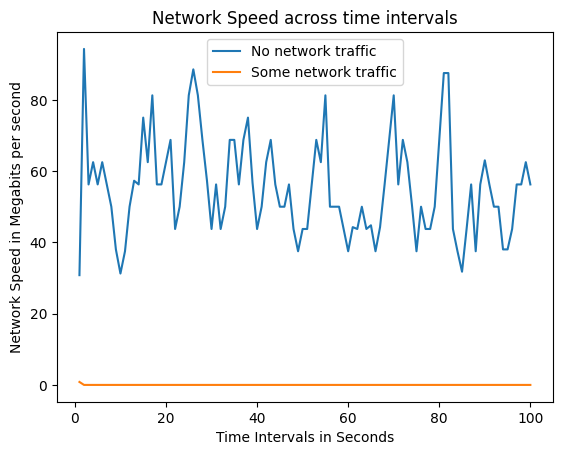

In [93]:
newy = []
new_ans = json.loads(json_data)
for i in range(len(new_ans['intervals'])):
    newy.append(new_ans['intervals'][i]['sum']['bits_per_second'] / 10**6)
    print(f"{new_ans['intervals'][i]['sum']['bits_per_second']:,}")
plt.plot(x, y)
plt.plot(x, newy)

plt.title('Network Speed across time intervals')
plt.xlabel('Time Intervals in Seconds')
plt.ylabel('Network Speed in Megabits per second')

plt.legend(['No network traffic', 'Some network traffic'])

In [2]:
from fabrictestbed_extensions.fablib.fablib import FablibManager as fablib_manager
fablib = fablib_manager()
slice = fablib.get_slice(name="lab1")
slice.delete()